# Static potential:circuit and hamiltonian

In [20]:
import qiskit

In [21]:
from scipy.sparse.linalg import eigsh
from qiskit.quantum_info import Statevector
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append("../../") # go to parent dir
from itertools import permutations
import primme

In [22]:
from Hamiltonian_QED_sym import HamiltonianQED_sym
from Hamiltonian_QED_oprt import HamiltonianQED_oprt
from HC_Lattice import HCLattice
from Ansaetze import Ansatz


In [23]:
from qiskit import QuantumCircuit, QuantumRegister,ClassicalRegister
from qiskit.quantum_info import Statevector
from qiskit.circuit import Parameter
import qiskit.quantum_info as qinf

##### Class Hamilt

In [24]:
#class input parameters:
n_sites = [3,3]#how many sites for every dimension
g=1
fact_e_op = 1
fact_b_op = 1
m=3
omega=1
l=1
L=8
rotors = False
lambd = 1000
encoding = 'gray' #'ed'#
magnetic_basis=False
pbc=False
puregauge = True 
static_charges_values =None#{(0,0):1,(1,0):-1}#TODO: no conditions applied, like charge conservation, etc. For conditions see func_qstatic_dist
display_hamiltonian=False
e_op_out_plus=False #if E out of site n has plus sign 
sparse_pauli=False
#lattice
latt = HCLattice(n_sites,pbc=pbc,puregauge=puregauge)

static_charges_values_input = latt.distances_coord
print(static_charges_values_input,latt.r_list,set(latt.r_list))

#static charge
qstat=static_charges_values_input[-1]

[{(0, 0): -1, (0, 1): 1} {(0, 0): -1, (0, 2): 1} {(0, 0): -1, (1, 0): 1}
 {(0, 0): -1, (1, 1): 1} {(0, 0): -1, (1, 2): 1} {(0, 0): -1, (2, 0): 1}
 {(0, 0): -1, (2, 1): 1} {(0, 0): -1, (2, 2): 1}] [1.0 2.0 1.0 1.4142135623730951 2.23606797749979 2.0 2.23606797749979
 2.8284271247461903] {1.0, 2.0, 2.23606797749979, 2.8284271247461903, 1.4142135623730951}


In [25]:
# Creating a configuration dictionary with common inputs
config = {
    'latt': latt,
    'n_sites': n_sites,
    'l':l,
    'L':L,
    'encoding':encoding,
    'magnetic_basis': magnetic_basis,
    'pbc': pbc,
    'puregauge': puregauge,
    'static_charges_values': qstat,
    'e_op_out_plus': e_op_out_plus
}
hamilt_sym = HamiltonianQED_sym(config)
class_H_oprt = HamiltonianQED_oprt( config,hamilt_sym, sparse_pauli=sparse_pauli)

HamiltonianQED_sym: Initializing...
> Gauss law equations solved
> e_op_free and u_op_free built
>> Gauss law applied and Hamiltonian built.  Execution time: 0.029626131057739258 seconds
HamiltonianQED_oprt: Initializing...
> e_op_free and u_op_free built
> Pauli strings built
>> Hamiltonian built.  Execution time: 2.1330068111419678 seconds
>> Suppression term built.  Execution time: 0.002357006072998047 seconds


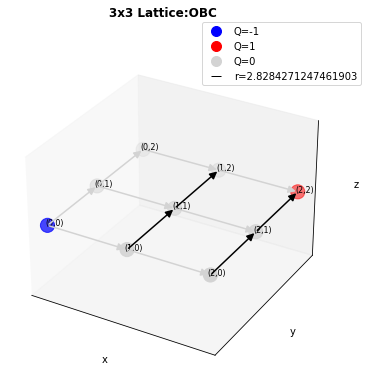

In [26]:
latt.draw_graph_func(gauss_law_fig=True,static_charges=qstat,e_op_free=class_H_oprt.e_op_free) 

In [27]:
Hamiltonian_Pauli_tot_vqd = class_H_oprt.get_hamiltonian(g_var=g, m_var=m, omega=omega,fact_b_op=fact_b_op,fact_e_op=fact_b_op,lambd=0)

#### Circuit

Total n.er of CNOT gates (Toffoli are decomposed): 176
Total n.er of parameters: 32


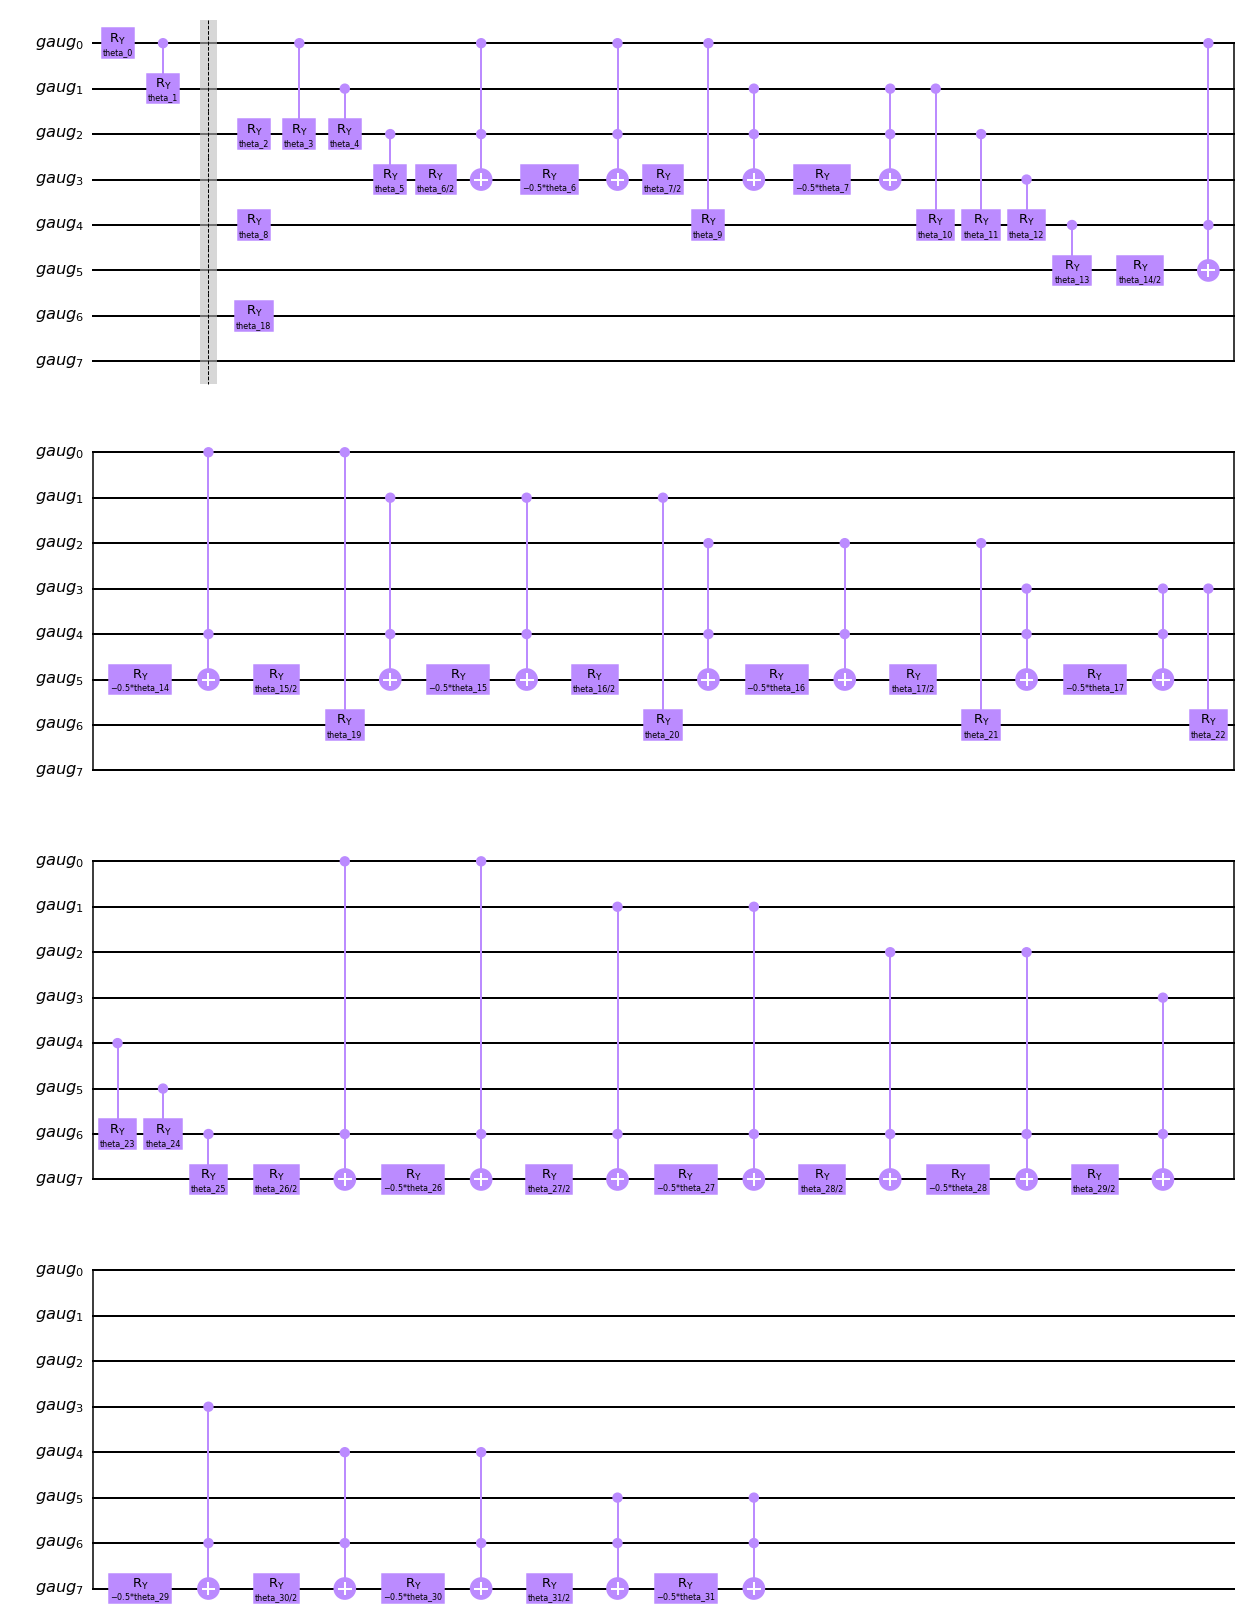

In [28]:
nlayers= 1
entanglement='full'
ngauge = class_H_oprt.len_e_op
if puregauge:
    n_qubits_f = 0
else:
    n_qubits_f = np.prod(latt.n_sites)

n_qubits =int(np.ceil(np.log2(2 * l+ 1)))

ansatz_class = Ansatz(l,ngauge,nfermions=n_qubits_f)

qc_tot2 = ansatz_class.puregauge_circuit_entang(entanglement=entanglement,rzlayer=False,nlayers=nlayers)[0]

print('Total n.er of CNOT gates (Toffoli are decomposed):',dict(qc_tot2.decompose().count_ops())['cx'])
print('Total n.er of parameters:',qc_tot2.num_parameters)
#print(ansatz_class.first_layer_par)
#parameter counts
#ansatz_class.parameters_count(n_qubits,ngauge)
qc_tot2.draw('mpl')

### Results

In [29]:
#results with random in. point
E_0_VQD_rnd = [-0.4098856350056715, 0.02063271582859444, -0.3888481626139586, -0.15444231175811976, 0.23911816192643612, 0.02003727303961476, 0.15290521098475723, 0.4668965387555446] 
stddev_VQD_rnd = [0.003588979120769063, 0.0035173147107962393, 0.005786821502957804, 0.0077799705342887805, 0.00786001216012681, 0.004186838608474029, 0.006426503508855556, 0.008588934573553891] 
#results with vacuum in. point
E_0_ED = [-0.42465209,0.00967512,-0.42465209,-0.19201086,0.16315688,-0.00169117,0.10796402,0.40138187,]
E_0_VQD= [-0.4123134134490866,0.02874743365795583,-0.41324046036836676,-0.18042912902622324,0.20135902261457364,0.01429026830852993,0.12744476387602804,0.4367853841258102]
stddev_VQD=[0.0032455841720200698,0.004094050866349575,0.004081987687297661,0.0034460230004808657,0.004575199973265965,0.004094018668451908,0.00460562650496565,0.005432938315498465]


E_0_ED = np.array(E_0_ED)[np.argsort(latt.r_list)]
E_0_VQD = np.array(E_0_VQD)[np.argsort(latt.r_list)]
stddev_VQD = np.array(stddev_VQD)[np.argsort(latt.r_list)]
E_0_VQD_rnd = np.array(E_0_VQD_rnd)[np.argsort(latt.r_list)]
stddev_VQD_rnd = np.array(stddev_VQD_rnd)[np.argsort(latt.r_list)]
latt_rlist_ordered = np.array(latt.r_list)[np.argsort(latt.r_list)].astype(float)

In [30]:
#fitting
from scipy.optimize import curve_fit
def func(x, a, b):
    return a * x + b

def func_log(x, a, b,c):
    return a * np.log(x) + b*x + c


fit log l=1 y=0.004220523452688418log(x)+0.44062523083323x+-0.8578780692312808


Text(0.5, 1.0, '3x3mbasisFalse puregaugeTrue g1 pbcFalse l1')

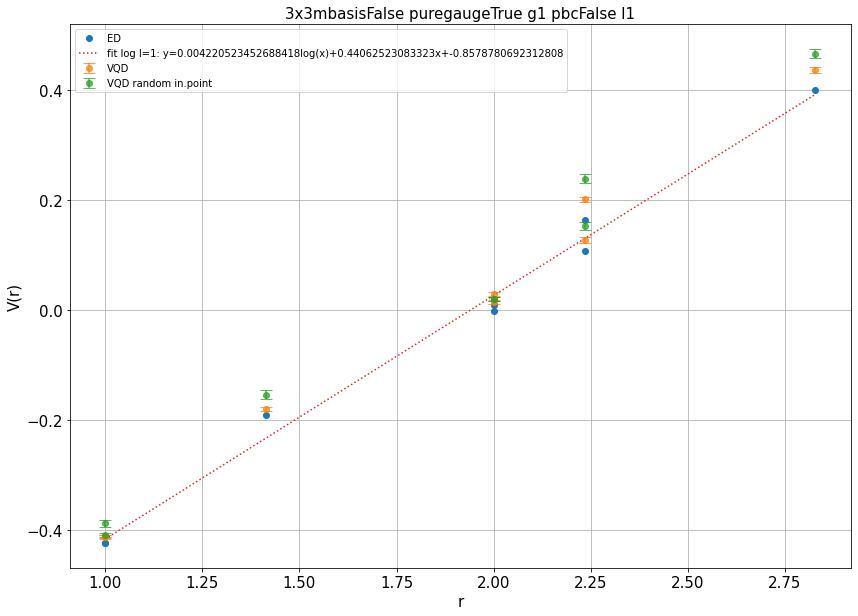

In [31]:
#
plt.figure(figsize=(14,10))
plt.plot(latt_rlist_ordered,E_0_ED,'o',label=f'ED')
plt.errorbar(latt_rlist_ordered, E_0_VQD, yerr=stddev_VQD,label=r"VQD",alpha=.75, fmt='o', capsize=6, capthick=1)
plt.errorbar(latt_rlist_ordered,E_0_VQD_rnd, yerr=stddev_VQD_rnd, label=r"VQD random in.point",alpha=.75, fmt='o', capsize=6, capthick=1)

popt, pcov = curve_fit(func_log, latt_rlist_ordered, E_0_ED)
plt.plot(latt_rlist_ordered, func_log(latt_rlist_ordered, *popt), label=f'fit log l={l}: y={popt[0]}log(x)+{popt[1]}x+{popt[2]}',linestyle='dotted')
print(f'fit log l={l} y={popt[0]}log(x)+{popt[1]}x+{popt[2]}')
#plt.ylim(-0.45,0.20)
plt.xlabel('r',size=15)
plt.ylabel('V(r)',size=15)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.grid()
plt.legend()
plt.title('x'.join(map(str,latt.n_sites))+f'mbasis{magnetic_basis} puregauge{puregauge} g{g} pbc{pbc} l{l}',size=15)

Text(0.5, 0.98, '3x3mbasisFalse puregaugeTrue g1 pbcFalse l1')

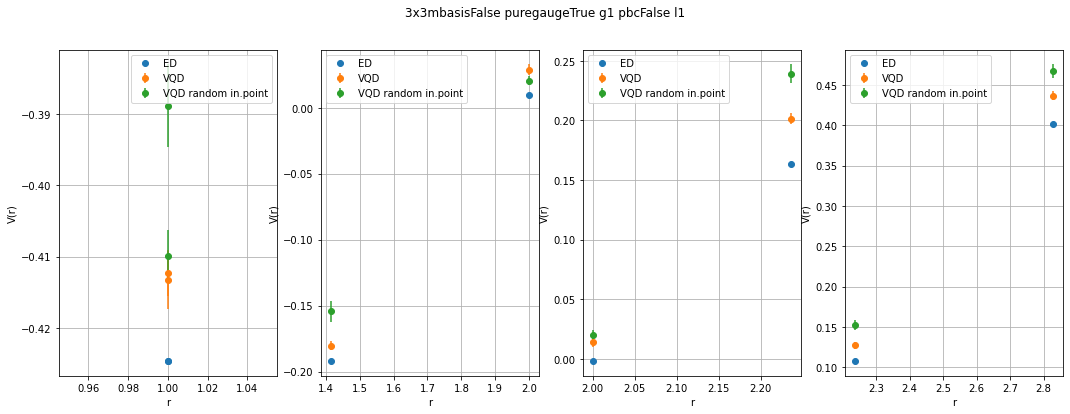

In [33]:
fig,ax = plt.subplots(1,4, figsize=(18, 6))

for n in range(4):
    ax[n].plot(latt_rlist_ordered[2*n:2*n+2],E_0_ED[2*n:2*n+2],'o',label=f'ED')
    ax[n].errorbar(latt_rlist_ordered[2*n:2*n+2], E_0_VQD[2*n:2*n+2], yerr=stddev_VQD[2*n:2*n+2], fmt='o',label=r"VQD")
    ax[n].errorbar(latt_rlist_ordered[2*n:2*n+2],E_0_VQD_rnd[2*n:2*n+2], yerr=stddev_VQD_rnd[2*n:2*n+2], fmt='o',label=r"VQD random in.point")
    
    ax[n].grid()
    ax[n].legend()
    ax[n].set_xlabel('r')
    ax[n].set_ylabel('V(r)')

fig.suptitle('x'.join(map(str,latt.n_sites))+f'mbasis{magnetic_basis} puregauge{puregauge} g{g} pbc{pbc} l{l}')